<h1><center>Proyecto final</center></h1>


<h2><center>Cómputo conexionista (A21)</center></h2>

---

<h3><center>

José Ángel Avelar Barragan (A200361)

José de Jesús Daniel Aguirre Arzate (A200350)
</center></h3>

---

<center><h2>"Identification of patterns in cosmic-ray arrival directions using dynamic graph convolutional neural networks"</center></h2>

---

Como proyecto final nos propusimos intentar entender el articulo y tratar de replicar los resultados. A la par intentamos relacionar los conceptos vistos en clase con lo que hace el articulo. Como primer objetivo tuvimos que entender como se estan procesando los datos y como objetivo final intentar construir la red que ellos proponen (tensorflow/pytorch).

#### Montado de Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




## <h2><center>Teoria</center></h2>

---

### **Problema:**
A traves de los patrones en las direcciones de arrivo de las particulas, distingir rayos cosmicos que vienen de la misma fuente o de un fondo isotropico (ruido de fondo).

Este metodo intenta encontrar patrones en las direcciones de arrivo de rayos cosmicos, si existen patrones se calsifica a las particulas como las que vienen de una fuente comun y las que vienen de direcciones de arribo isotropicas.

Datos de entrenamiento: Simulaciones simples de direcciones de arribo donde se conoce la unica fuente que genera algunos rayos cosmicos(+ detalles en el articulo acerca de la configuracion del simulador BENCHMARK1)

![Simulated arrival directions](images/skymap_0.png)


### Bloque de imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

import os
import time
import pickle

from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as lay

print(f"TensorFlow version: {tf.__version__}")
print(f"Pytorch version: {torch.__version__}")

TensorFlow version: 2.5.0
Pytorch version: 1.9.0+cu102


In [3]:
#Intentando usar astrotools
try:
    import astrotools
    from astrotools import auger, coord, skymap
except ModuleNotFoundError: 
    print("Instalandolo entonces\n")
    !pip install healpy
    !pip install astrotools
from astrotools import skymap


<h2><center>Preparacion de datos</center></h2>

---

El dataset *dataset_HAP.npz* esta organizado de la siquiente manera:

Un diccionario con las keys: data, label
En las cuales en data esta un arreglo de 50000 simulaciones de 500 particulas cada una con sus respectivas coordenadas (x,y,z, E) donde E es la energia normalizada. 

Y el arreglo que viene en label clasifica a 1 como aaquellas simulaciones que tienen una fuente o 0 como aquellas que solo son arrivos isotropicos. 

In [4]:
!ls "/content/drive/MyDrive/Proyecto/data/cosmic_ray_sphere" #Path de José Ángel


dataset_HAP.npz


In [5]:
dir ="/content/drive/MyDrive/Proyecto/data/cosmic_ray_sphere/"

In [6]:
#Ruta de Jose para edgeConv.py
dir2 =  "/content/drive/MyDrive/Colab Notebooks/"

In [7]:
def deflected_cosmic_rays():
    file = np.load(dir+"dataset_HAP.npz")
    x_train, x_test = file["data"][:-10000], file["data"][-10000:]
    labels = tf.keras.utils.to_categorical(file["label"],num_classes=2)
    y_train, y_test = labels[:-10000], labels[-10000:]
    return x_train, x_test, y_train, y_test

In [8]:
#Demora unos segundos
X_train, X_test, y_train, y_test = deflected_cosmic_rays()

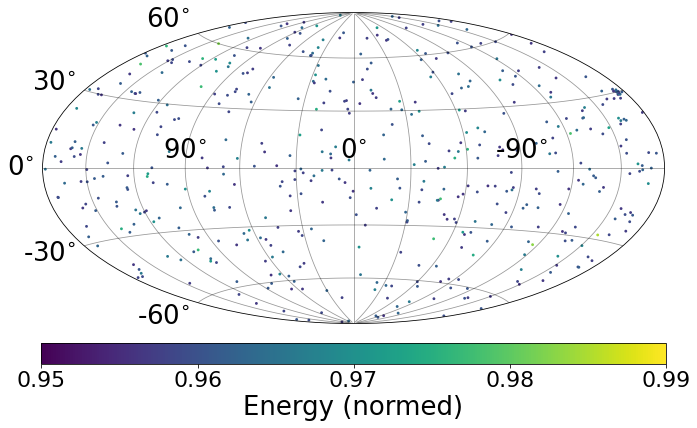

<Figure size 864x432 with 0 Axes>

In [9]:
test_id = 0
example_map = X_test[0]
skymap.eventmap(example_map[:,0:3].T, c=example_map[:,3], cblabel='Energy (normed)', opath="skymap_%i.png" % test_id)
im = Image.open("skymap_0.png")
im

In [10]:
train_points, test_points, train_features, test_features = X_train[...,:3], X_test[...,:3], X_train[...,-1, np.newaxis], X_test[...,-1, np.newaxis]
train_input_data, test_input_data = [train_points, train_features],[test_points, test_features]

### EdgeConv 
La convolución de aristas se basa en obtener caracteristicas invariantes a la permutación de la geometria local de un grafo, en lugar de obtenerlas de los embbedings del mismo. \
En particular se trata de un invariante al reordenamiento de los vecinos, ya que la función *construye* un grafo local y extrae los embedings de las aristas.

### K-nn
Para poder construir un grafo local se implementa el método de K-nn dónde el grafo generado depende del número de vecinos de cada nodo tales que estos sean los que están más cerca de este. \
En esta implementación se emplea el cálculo de la distancia euclideana entre los puntos y la misma capa convolucional realiza esta operación.

### $h_\Theta$ Función no lineal del mensaje

En este caso la función encargada de la no linealidad del mensaje es una MLP (detallada en arquitectura), esta también cumple con ajustar el tamaño del mensaje modificando así el número de caracteristicas asociados a cada nodo por capa de edgeConv. 

$$ h_{\theta} (x_{i,c},x_{i_j,c})= NN_\theta ( x_{i,c} , x_{i,c} - x_{i_j,c} )$$

### Agregación

La agregación del mensaje se hace por cada vecino que nos devuelve un mensaje, siendo descrita como:

$$ x_{i,c}' = \frac{1}{k_n} \sum \ h_{\theta}(x_{i,c},x_{i_j,c})$$

Notemos que este paso incluye al nodo central como parte del mensaje  *self-loop* pero concatena las caracteristicas del nodo con las caracteristicas de arista para obtener un nuevo vector enriquesido de caracteristicas que pasaran a la siguiente capa.



### Dynamic Graph

Se considera que la implementación es un gráfo dinámico ya que tras cada iteración se extiende el vector de coordenadas con las caracteristicas obtenidas por la capa previa, de forma que el k-nn formado por cada capa difiere del anterior. \
Presumimos que aquellos más similares se aproximarán en cada iteración, como se ilustra en: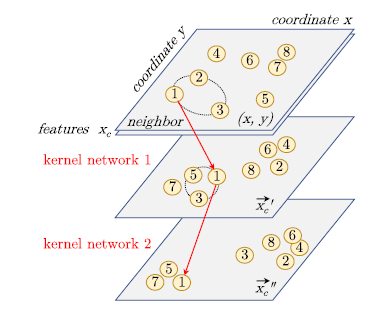


### Modelo completo
A continuación se declaran algunas de las caracteristicas y detalles de la arquitectura en cuestión:
- Separación de las entradas y aplicación de BatchNorm a las Caracteristicas (Energía)
- Incersión de las Coordenadas, concatenandolas con las caracteristicas antes de cada EdgeConv
- Aplicación de 3 EdgeConv, con unidades ReLU, 16 vecinos y  16,32 y 64 nodos en sus capas Densas respectivamente.
- GlobalAveragePooling, para emplear capas Densas
- Dos capas densas de 256 y 2 unidades con ReLU y SoftMax como activación.
- BatchNorm con momento 0.9 y $\epsilon \ 10^{-5}$
- Optimizador Adam, con Lr variable (decaimiento de $10^{-3}$ a $10^{-5}$ y decaimiento coseno)
- Metricas: Entropía Cruzada Categorica y Presición

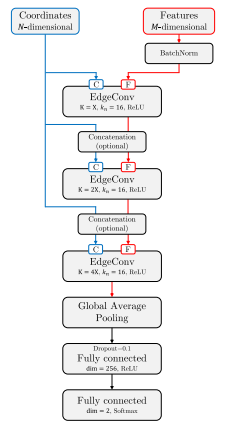
 

## <h2><center>Implementacion</center></h2>

---

 
- <h3>Tensorflow</h3>

#### Importando edgeConv

In [11]:
os.chdir(dir2)

In [12]:
from edgeConv import EdgeConv

José de Jesus

In [13]:
NODES=16

LAYERS = tf.keras.layers
def kernel_nn(data, nodes=NODES):
    d1, d2 = data

    delta = LAYERS.Subtract()([d1,d2])
    x = LAYERS.Concatenate(axis=-1)([d1,delta])

    x = LAYERS.Dense(nodes, activation="relu")(x)
    x = LAYERS.BatchNormalization()(x)

    x = LAYERS.Dense(nodes, activation="relu")(x)
    x = LAYERS.BatchNormalization()(x)

    x = LAYERS.Dense(nodes, activation="relu")(x)
    x = LAYERS.BatchNormalization()(x)
    return x    

points_input = LAYERS.Input((500,3))
feats_input = LAYERS.Input((500,1))


x = EdgeConv(lambda a: kernel_nn(a, nodes=8), next_neighbors=5)([points_input, feats_input])
x = LAYERS.Activation("relu")(x)
x = EdgeConv(lambda a: kernel_nn(a, nodes=16), next_neighbors=8)([points_input, x])
x = LAYERS.Activation("relu")(x)
y = EdgeConv(lambda a: kernel_nn(a, nodes=32), next_neighbors=16)([points_input, x])
x = LAYERS.Activation("relu")(y)
x = LAYERS.GlobalAveragePooling1D(data_format='channels_first')(x)
out = LAYERS.Dense(2, activation="softmax")(x)

model = tf.keras.models.Model([points_input, feats_input], out)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500, 3)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 500, 1)]     0                                            
__________________________________________________________________________________________________
edge_conv (EdgeConv)            (None, 500, 8)       264         input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 500, 8)       0           edge_conv[0][0]              

In [14]:
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(3E-3, decay=1E-4),metrics=['acc'])

BATCH_SIZE = 64
EPOCHS     = 10
hist = model.fit(train_input_data, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/10
625/625 [==============================] - 152s 236ms/step - loss: 0.5867 - acc: 0.6385
Epoch 2/10
625/625 [==============================] - 152s 243ms/step - loss: 0.4534 - acc: 0.7800
Epoch 3/10
625/625 [==============================] - 152s 243ms/step - loss: 0.4173 - acc: 0.8045
Epoch 4/10
625/625 [==============================] - 152s 243ms/step - loss: 0.3988 - acc: 0.8161
Epoch 5/10
625/625 [==============================] - 152s 243ms/step - loss: 0.3860 - acc: 0.8242
Epoch 6/10
625/625 [==============================] - 152s 243ms/step - loss: 0.3723 - acc: 0.8333
Epoch 7/10
625/625 [==============================] - 152s 243ms/step - loss: 0.3636 - acc: 0.8373
Epoch 8/10
625/625 [==============================] - 152s 243ms/step - loss: 0.3540 - acc: 0.8429
Epoch 9/10
625/625 [==============================] - 152s 243ms/step - loss: 0.3482 - acc: 0.8475
Epoch 10/10
625/625 [==============================] - 152s 243ms/step - loss: 0.3422 - acc: 0.8529


In [15]:
def plot_hist(history):
    fig, axes = plt.subplots(2, figsize=(12,8))
    if type(history) == dict:
        loss = history["loss"]
        acc = history["acc"]
    else:
        loss, acc = np.split(np.array(history), 2, axis=-1)
    x = np.arange(len(loss))
    axes[0].plot(x, loss, c="navy")
    axes[0].set_yscale("log")
    axes[0].set_ylabel("Loss")
    axes[1].plot(x, acc, c="firebrick")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_ylim(0, 1)
    if type(history) == dict:
        axes[0].set_xlabel("Epochs")
        axes[1].set_xlabel("Epochs")
    else:
        axes[0].set_xlabel("Iterations")
        axes[1].set_xlabel("Iterations")
    fig.tight_layout()
    return fig

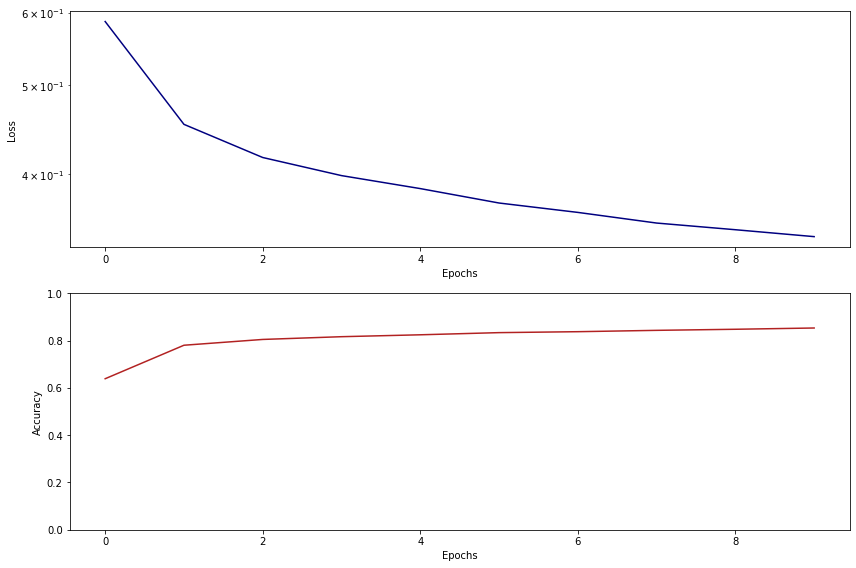

In [16]:
fig = plot_hist(hist.history)
fig.savefig("./history.png")

José Ángel

In [17]:


#para dar el shape
points = lay.Input((500, 3))
feats  = lay.Input((500, 1))

In [18]:


class MyModel(tf.keras.Model):

  def __init__(self):
    super(MyModel, self).__init__()

    self.edge1 = EdgeConv(lambda a: kernel_nn(a, nodes=16), next_neighbors=16)
    self.edge2 = EdgeConv(lambda a: kernel_nn(a, nodes=32), next_neighbors=16)
    self.edge3 = EdgeConv(lambda a: kernel_nn(a, nodes=64), next_neighbors=16)
    self.drop1  = lay.Dropout(0.1)
    self.batch1 = lay.BatchNormalization(momentum=0.9, epsilon=1e-5)

    
    self.GAP1D  = lay.GlobalAveragePooling1D(data_format='channels_first' )
    self.Dense1  = lay.Dense(256,activation='relu')
    self.Dense2  = lay.Dense(2,activation='softmax')

    

  def call(self, inputs):
    points,feats = inputs
    
    feats = self.batch1(feats)
    
    x =  self.edge1([points,feats]) 
    x =  lay.Activation("ReLU")(x)
    x =  self.edge2([points,x]) 
    x =  lay.Activation("ReLU")(x)
    x =  self.edge3([points,x]) 
    x =  lay.Activation("ReLU")(x)
    
    x  = self.GAP1D(x)
    x  = self.Dense1(x)
    x  = self.drop1(x)
    out  = self.Dense2(x)
  
    return out


In [19]:
points.shape,feats.shape # Batch, nodos, caraceristicas


(TensorShape([None, 500, 3]), TensorShape([None, 500, 1]))

In [20]:
model_C = MyModel()

In [21]:
model_C.build([points.shape,feats.shape])
model_C.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
edge_conv_3 (EdgeConv)       multiple                  264       
_________________________________________________________________
edge_conv_4 (EdgeConv)       multiple                  1008      
_________________________________________________________________
edge_conv_5 (EdgeConv)       multiple                  3552      
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
batch_normalization (BatchNo multiple                  4         
_________________________________________________________________
global_average_pooling1d_1 ( multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  128

In [22]:
#Caída del LR
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(1e-4,decay_steps=1000)

model_C.compile(loss= "categorical_crossentropy",metrics="acc", optimizer=keras.optimizers.Adam(learning_rate=lr_schedule))


In [23]:
hist2 = model_C.fit(train_input_data, y_train, epochs=10, batch_size=64)

Epoch 1/10
625/625 [==============================] - 121s 188ms/step - loss: 0.7000 - acc: 0.5064
Epoch 2/10
625/625 [==============================] - 117s 188ms/step - loss: 0.6870 - acc: 0.5380
Epoch 3/10
625/625 [==============================] - 117s 187ms/step - loss: 0.6858 - acc: 0.5414
Epoch 4/10
625/625 [==============================] - 117s 188ms/step - loss: 0.6855 - acc: 0.5445
Epoch 5/10
625/625 [==============================] - 117s 187ms/step - loss: 0.6859 - acc: 0.5416
Epoch 6/10
625/625 [==============================] - 117s 187ms/step - loss: 0.6860 - acc: 0.5422
Epoch 7/10
625/625 [==============================] - 117s 187ms/step - loss: 0.6862 - acc: 0.5396
Epoch 8/10
625/625 [==============================] - 117s 187ms/step - loss: 0.6856 - acc: 0.5422
Epoch 9/10
625/625 [==============================] - 117s 187ms/step - loss: 0.6861 - acc: 0.5404
Epoch 10/10
625/625 [==============================] - 117s 187ms/step - loss: 0.6859 - acc: 0.5396


In [24]:
#Usando nuestros datos:
model_C.predict([ np.reshape(X_train[0,:,0:3],(-1,500,3)),np.reshape(X_train[0,:,3],(-1,500,1)) ] ), y_train[0]


(array([[0.45339555, 0.54660445]], dtype=float32),
 array([0., 1.], dtype=float32))

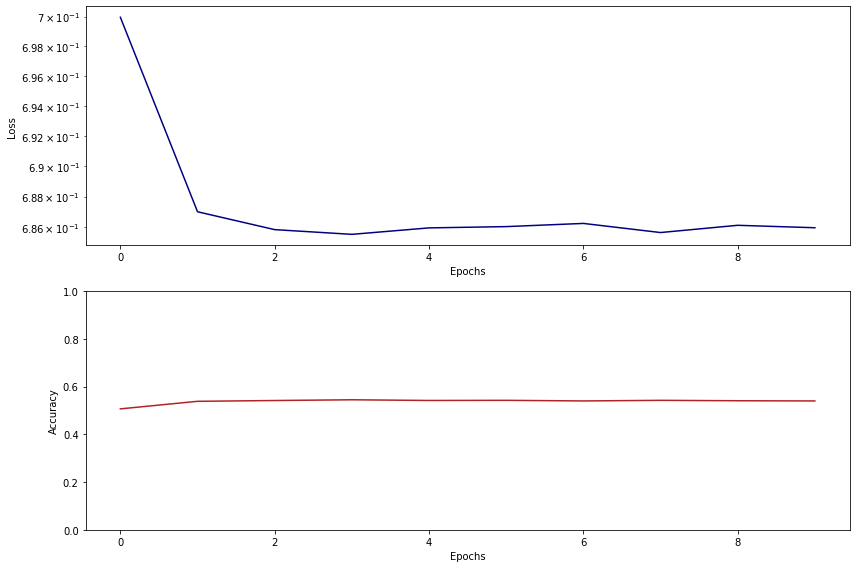

In [25]:
fig = plot_hist(hist2.history)
fig.savefig("./history2.png")

## Enlace a Git de nuestro intento de replicar:
https://github.com/gsusAguirreArz/proyectoConexionistaA21


## Referencias:

- Bister, T., Erdmann, M., Glombitza, J., Langner, N., Schulte, J., & Wirtz, M. (2021). Identification of patterns in cosmic-ray arrival directions using dynamic graph convolutional neural networks. Astroparticle Physics, 126, 102527.
https://www.sciencedirect.com/science/article/pii/S0927650520300992

- Wang, Y., Sun, Y., Liu, Z., Sarma, S. E., Bronstein, M. M., & Solomon, J. M. (2019). Dynamic graph cnn for learning on point clouds. Acm Transactions On Graphics (tog), 38(5), 1-12. \
https://dl.acm.org/doi/abs/10.1145/3326362

- EdgeConv \
https://git.rwth-aachen.de/niklas.langner/edgeconv_keras

- SOURCE CODE FOR TORCH_GEOMETRIC.NN.CONV.EDGE_CONV \
https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/conv/edge_conv.html